In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.plots import *
import planet
from planet import f2, opt_th

In [6]:
path = '../data/planet/' #path to folder containing data
sz=256   #image size
bs=64    #batch size 

In [39]:
metrics=[f2]
f_model = resnet34


In [9]:
label_csv = f'{path}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [11]:
data = planet.get_data_zoom(f_model, path, sz, bs, n, 0)

In [12]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [27]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.20253  0.2786   0.82396]                        



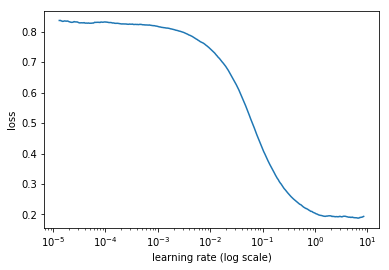

In [28]:
learn.sched.plot()

In [29]:
lr=0.2
lrs = np.array([lr/9, lr/3,lr])

In [30]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.12986  0.11727  0.8986 ]                        
[ 1.       0.12256  0.11174  0.9037 ]                        
[ 2.       0.1193   0.10926  0.90621]                        
[ 3.       0.12054  0.1084   0.90818]                        
[ 4.       0.11481  0.10655  0.90906]                        
[ 5.       0.11321  0.10535  0.91091]                        
[ 6.       0.11107  0.10494  0.9111 ]                        



In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09803  0.09488  0.92107]                         
[ 1.       0.09656  0.09234  0.92265]                         
[ 2.       0.09345  0.08786  0.92667]                         
[ 3.       0.09318  0.0916   0.92153]                         
[ 4.       0.08936  0.08886  0.92285]                         
[ 5.       0.0872   0.08492  0.92907]                         
[ 6.       0.08361  0.08434  0.92942]                         



In [32]:
-learn.save('resnet34.weights.1')

In [13]:
learn.load('resnet34.weights.1')

In [49]:
## do more data augmentation

In [52]:
np.random.shuffle(val_idxs)
val_idx_2 = val_idxs[0:len(val_idxs)//4]
len(val_idx_2), len(val_idxs)

(2023, 8095)

In [55]:
def get_data_x(sz, bs):
    tfms = tfms_from_model(f_model, sz, aug_tfms = transforms_basic+[RandomFlipXY(), RandomDihedralXY()], max_zoom=1.05)
    return mageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms, suffix='.jpg', val_idxs=val_idx_2, test_name='test-jpg')

In [56]:
learn.freeze()
learn.fit(lr, 1, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.08361  0.08443  0.92913]                         



In [57]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.08539  0.08505  0.92841]                         
[ 1.       0.08788  0.08651  0.92795]                         
[ 2.       0.07998  0.08434  0.92927]                         
[ 3.       0.08667  0.08629  0.9287 ]                         
[ 4.       0.08441  0.08471  0.92874]                         
[ 5.       0.0804   0.08439  0.92912]                         
[ 6.       0.07779  0.08386  0.92959]                         



In [14]:
log_probs, y = learn.TTA()

## Ensembling

In [22]:
def get_ensumble(nmodels):
    train_len = len(list(open(label_csv)))-1
    bs=64
    models = list()
    for i in range(nmodels):
        print(f'======Training model {i+1}======')
        val_idx = get_cv_idxs(train_len)
        data = ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, get_transform(i), suffix='.jpg', val_idxs=val_idx, test_name='test-jpg')
        lr=0.2
        lrs=[lr/9, lr/3, lr]
        learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
        
        learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
        learn.unfreeze()
        learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
        #learn.save(f'ensum_model_{i}')
        models.append(learn)
        print(f'======Training of model {i+1} completed======')
    return models
        
    
def load_pretrained_ensumble(nmodels):
    for i in rang(nmodels)
    
def get_transform(index):
    sz=256
    tfms = [
        tfms_from_model(f_model, sz, aug_tfms =transforms_basic, max_zoom=1.05),
        tfms_from_model(f_model, sz, aug_tfms =transforms_side_on, max_zoom=1.05),
        tfms_from_model(f_model, sz, aug_tfms =transforms_top_down, max_zoom=1.05),
        tfms_from_model(f_model, sz, aug_tfms =transforms_top_down, max_zoom=1.1),
        tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05, crop_type=CropType.RANDOM)]
    return tfms[index]


    
    
    
    

In [23]:
ens = get_ensumble(5)

======Training model 1======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  3%|▎         | 16/506 [00:02<01:02,  7.84it/s, loss=0.833]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/irshad/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/irshad/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/irshad/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.12706  0.11708  0.89822]                        
[ 1.       0.12242  0.11106  0.90476]                        
[ 2.       0.12011  0.10906  0.90736]                        
[ 3.       0.12028  0.10774  0.90716]                        
[ 4.       0.11858  0.10688  0.90931]                        
[ 5.       0.11182  0.10528  0.9106 ]                        
[ 6.       0.11024  0.10521  0.91021]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09855  0.0926   0.92454]                         
[ 1.       0.09529  0.09104  0.9247 ]                         
[ 2.       0.08777  0.08876  0.92563]                         
[ 3.       0.08959  0.09153  0.92314]                         
[ 4.       0.08416  0.08923  0.92606]                         
[ 5.       0.07648  0.08868  0.9252 ]                         
[ 6.       0.07011  0.08904  0.9256 ]                         

======Training of model 1 completed======
======Training model 2======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.12949  0.11757  0.89717]                        
[ 1.       0.12388  0.11223  0.90098]                        
[ 2.       0.1185   0.10939  0.90494]                        
[ 3.       0.11944  0.10821  0.90537]                        
[ 4.       0.11611  0.10686  0.90908]                        
[ 5.       0.11359  0.10535  0.90928]                        
[ 6.       0.11448  0.10541  0.90976]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09919  0.09308  0.92268]                         
[ 1.       0.0954   0.09171  0.92238]                         
[ 2.       0.08968  0.08708  0.92733]                         
[ 3.       0.09526  0.09066  0.92308]                         
[ 4.       0.08839  0.08843  0.92463]                         
[ 5.       0.08162  0.08515  0.92944]                         
[ 6.       0.07965  0.08563  0.92763]                         

======Training of model 2 completed======
======Training model 3======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.13027  0.11571  0.89997]                        
[ 1.       0.12552  0.11079  0.90551]                        
[ 2.       0.1213   0.10958  0.90608]                        
[ 3.       0.12113  0.10982  0.90485]                        
[ 4.       0.11484  0.10658  0.90941]                        
[ 5.       0.11505  0.10604  0.90897]                        
[ 6.       0.11621  0.10558  0.90978]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.1023   0.09398  0.92121]                        
[ 1.       0.09992  0.09138  0.92061]                         
[ 2.       0.08975  0.08789  0.92552]                         
[ 3.       0.09437  0.08933  0.92533]                         
[ 4.       0.08957  0.08619  0.92812]                         
[ 5.       0.08281  0.08564  0.92699]                         
[ 6.       0.08582  0.08497  0.92875]                         

======Training of model 3 completed======
======Training model 4======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.13437  0.11698  0.89935]                        
[ 1.       0.12518  0.11186  0.90352]                        
[ 2.       0.12355  0.10992  0.90558]                        
[ 3.       0.11908  0.10826  0.90768]                        
[ 4.       0.11888  0.10686  0.90818]                        
[ 5.       0.11798  0.10569  0.90935]                        
[ 6.       0.11304  0.10508  0.91011]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.10187  0.09447  0.92077]                        
[ 1.       0.09815  0.09061  0.92627]                         
[ 2.       0.09016  0.08874  0.92514]                         
[ 3.       0.09555  0.09128  0.92278]                         
[ 4.       0.08926  0.08697  0.9275 ]                         
[ 5.       0.08706  0.08553  0.92757]                         
[ 6.       0.08548  0.08491  0.92838]                         

======Training of model 4 completed======
======Training model 5======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/506 [00:00<?, ?it/s]


NameError: name 'im' is not defined

In [ ]:
train_len = len(list(open(label_csv)))-1
bs=64
i=4
print(f'======Training model {i+1}======')
val_idx = get_cv_idxs(train_len)
tfms=tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05, crop_type=CropType.RANDOM) 
data = ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms, suffix='.jpg', val_idxs=val_idx, test_name='test-jpg')
lr=0.2
lrs=[lr/9, lr/3, lr]
learn = ConvLearner.pretrained(f_model, data, metrics=metrics, )   
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'ensum_model_{i}')
print(f'======Training of model {i+1} completed======')
    



======Training model 5======


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.13096  0.11658  0.89982]                        
[ 1.       0.12356  0.11179  0.90351]                        
[ 2.       0.12051  0.1091   0.90641]                        
[ 3.       0.12032  0.10886  0.90715]                        
[ 4.       0.11889  0.1065   0.90922]                        
[ 5.       0.11706  0.10474  0.91115]                        
[ 6.       0.1133   0.10557  0.90972]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.10384  0.09476  0.92036]                         
[ 1.       0.0953   0.09005  0.92528]                         
[ 2.       0.09224  0.08818  0.92734]                         
 65%|██████▍   | 328/506 [01:26<00:46,  3.81it/s, loss=0.0975]

In [40]:
metrics


[<function planet.f2>]

In [75]:
np.max(log_probs), np.min(log_probs)

(0.99999976, 9.9490105e-09)

In [63]:
preds = np.mean(log_probs, axis=0)

In [66]:
f2(preds, y)

0.93105820894847946

In [79]:
exp_probs= np.mean(np.exp(log_probs), axis=0)
f2(exp_probs, y)

0.48394347741367771

In [68]:
opt_th=planet.opt_th(preds,y)

## Preparing the predicitons

In [69]:
%time test_preds, _ = learn.TTA(is_test=True)
preds = np.mean(test_preds, axis=0)

CPU times: user 24min 58s, sys: 2min 44s, total: 27min 42s
Wall time: 5min 23s


In [72]:
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp>opt_th))]) for pp in preds])
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.head()

,tags
file_19774,cloudy
file_9129,clear primary water
test_19405,clear primary
file_10086,clear primary water
file_5426,clear primary


In [74]:
frame.to_csv(f'{path}planet_amazon_restnet34_submission1.csv', index_label='image_name')